<a href="https://colab.research.google.com/github/ttya16/LSMT_IMDB_sentiment_analysis/blob/master/IMDB_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LSTMモデルによるIMDBデータセットのネガポジ分析検証

**目的**
* 単語の分散表現を用いたRNNモデルを自分で実装してみる。
* 実際にどれくらいの精度が出るのか試してみる。

### ノートブックの準備
* ノートブックの設定はハードウェアアクセラレータをGPUにしておく。
* imdbデータセットをダウンロードするのだが、numpyのバージョンが新しいとエラーになるようなので、正常に動くバージョンへ下げる。

### IMDBデータセット
映画の投稿レビューテキストに対して「肯定的」か「否定的」かのラベルづけがされたデータセット。<br>
kerasライブラリ経由でダウンロードが可能。(numpyのバージョンを1.16.2に合わせる必要がある)<br>

[keras datasets](https://keras.io/ja/datasets/)<br>
[IMDBのサイト](https://www.imdb.com/)

In [1]:
!pip install numpy==1.16.2

### 必要なライブラリの準備

In [2]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, CuDNNLSTM, BatchNormalization
from keras.datasets import imdb

import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

Using TensorFlow backend.


### ハイパーパラメータなど

In [0]:
NUM_VOCAB = 10000 #語彙数
MAX_LEN = 200 #入力シーケンスの長さ
EMBEDDING_DIMS = 16 #分散表現の次元数
BATCH_SIZE = 64 #学習バッチのサイズ
EPOCHS = 20 #学習エポック数

### IMDBデータセットのダウンロード

In [8]:
(x_train, y_train), (x_val, y_val) = imdb.load_data(num_words = NUM_VOCAB, index_from=3)

print("trainデータサイズ",len(x_train))
print("valデータサイズ", len(x_val))

for sample in range(10):
  print(x_train[sample])

trainデータサイズ 25000
valデータサイズ 25000
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
[1, 194, 1153, 194, 8255, 

In [9]:
#入力シーケンスの長さを統一するために後方でpaddingする。
print("before padding:", x_train.shape)
x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN, padding="post", truncating="post")
x_val = sequence.pad_sequences(x_val, maxlen=MAX_LEN, padding="post", truncating="post")
print("after padding:", x_train.shape)

before padding: (25000,)
after padding: (25000, 200)


In [10]:
print(x_train[1])

[   1  194 1153  194 8255   78  228    5    6 1463 4369 5012  134   26
    4  715    8  118 1634   14  394   20   13  119  954  189  102    5
  207  110 3103   21   14   69  188    8   30   23    7    4  249  126
   93    4  114    9 2300 1523    5  647    4  116    9   35 8163    4
  229    9  340 1322    4  118    9    4  130 4901   19    4 1002    5
   89   29  952   46   37    4  455    9   45   43   38 1543 1905  398
    4 1649   26 6853    5  163   11 3215    2    4 1153    9  194  775
    7 8255    2  349 2637  148  605    2 8003   15  123  125   68    2
 6853   15  349  165 4362   98    5    4  228    9   43    2 1157   15
  299  120    5  120  174   11  220  175  136   50    9 4373  228 8255
    5    2  656  245 2350    5    4 9837  131  152  491   18    2   32
 7464 1212   14    9    6  371   78   22  625   64 1382    9    8  168
  145   23    4 1690   15   16    4 1355    5   28    6   52  154  462
   33   89   78  285   16  145   95    0    0    0    0    0    0    0
    0 

入力長が200になるように、200以下だったものは後方を0で埋めて不足分を補う形にしている。

### 学習の準備
学習用のデータを少し増やしたいので、x_valの半分を学習用に回してデータを再編成。

In [0]:
X_tr = np.concatenate((x_train, x_val[:12500]), axis = 0)
y_tr = np.concatenate((y_train, y_val[:12500]), axis=0)

X_test = x_val[12500:]
y_test = y_val[12500:]

### モデルの準備
以下のようなLSTMセルを用いたRNNモデルを準備した。<br>

In [0]:
model_lstm = Sequential()
model_lstm.add(Embedding(NUM_VOCAB, EMBEDDING_DIMS, input_length=MAX_LEN))
model_lstm.add(CuDNNLSTM(64, return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(CuDNNLSTM(32))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [18]:
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 16)           160000    
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 200, 64)           20992     
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 64)           256       
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 193,825
Trainable params: 193,697
Non-trainable params: 128
_________________________________________________________________


In [19]:
history = model_lstm.fit(X_tr, y_tr,
                                           batch_size=BATCH_SIZE,
                                           epochs=EPOCHS, 
                                           verbose=1,
                                           validation_split=0.2)

Train on 30000 samples, validate on 7500 samples
Epoch 1/10
30000/30000 [==============================] - 42s 1ms/step - loss: 0.6392 - acc: 0.6323 - val_loss: 0.7644 - val_acc: 0.5001
Epoch 2/10
30000/30000 [==============================] - 40s 1ms/step - loss: 0.5348 - acc: 0.7482 - val_loss: 0.7136 - val_acc: 0.6753
Epoch 3/10
30000/30000 [==============================] - 40s 1ms/step - loss: 0.4455 - acc: 0.8074 - val_loss: 1.1172 - val_acc: 0.5352
Epoch 4/10
30000/30000 [==============================] - 40s 1ms/step - loss: 0.3969 - acc: 0.8296 - val_loss: 0.7777 - val_acc: 0.5684
Epoch 5/10
30000/30000 [==============================] - 40s 1ms/step - loss: 0.3318 - acc: 0.8663 - val_loss: 0.4641 - val_acc: 0.7855
Epoch 6/10
30000/30000 [==============================] - 40s 1ms/step - loss: 0.2872 - acc: 0.8872 - val_loss: 0.4169 - val_acc: 0.8263
Epoch 7/10
30000/30000 [==============================] - 40s 1ms/step - loss: 0.2401 - acc: 0.9116 - val_loss: 0.4050 - val_acc:

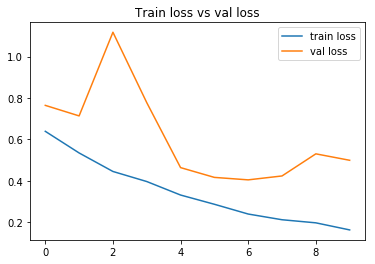

In [20]:
plt.figure()
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Train loss vs val loss")
plt.legend()
plt.show()

## モデルの性能を確認


In [0]:
#imdbの単語->Index対応の辞書をダウンロードする
word_index = imdb.get_word_index()

**IMDBの単語-Indexの対応については上でダウンロードした辞書によってそのまま対応づけられている訳ではなく、実際は3ずれたIndexが当てられている。**
<br>
ずれた3つのindex1~3はそれぞれ、
* シーケンスの開始地点を示すindicator: 1
* 語彙にない単語を示すindicator: 2
* 3は使われていない。(kerasにおける些細なミスと思われる)
となっている。<br>

pad_sequencesによりpadding部分は全て0が割り当てられるようになっているため、以下のコードのように調整してやれば良い。


[参考](https://jamesmccaffrey.wordpress.com/2018/04/27/inspecting-the-imdb-dataset-reverse-mapping-the-index-values/)

In [0]:
word_index_fixed = {k:v+3 for k, v in word_index.items()}
word_index_fixed["<PAD>"] = 0
word_index_fixed["<START>"] = 1
word_index_fixed["<UNK>"] = 2

Index->単語対応の辞書も用意する。

In [25]:
index_word = dict([(value, key) for (key, value) in word_index_fixed.items()])
index_word[0]

'<PAD>'

In [27]:
sample_text = " ".join([index_word[idx] for  idx in x_train[1]])
print(sample_text)

<START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal <UNK> the hair is big lots of boobs <UNK> men wear those cut <UNK> shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then <PAD> <PAD> <PAD> <PAD> 

### モデルによるテストデータの出力を検証

In [0]:
pred = model_lstm.predict(X_test)

In [30]:
pred.shape

(12500, 1)

In [31]:
print(pred[0])
print(y_test[0])

[0.00675032]
0


In [0]:
#入力テキストをモデルに入力するための前処理
import re

def review_preprocessing(review, word_to_index, maxlen):
  
  rev = review.lower() #全部小文字にする
  rev = re.sub(r"[.,]", "", rev) #ピリオド,コンマは省く
  rev = rev.strip().split() #不要なスペースは除き、スペースごとで単語を区切る
  
  review_data=[1]
  for word in rev:
    try:
      review_data.append(word_to_index[word])
    except:
      review_data.append(2)
    
  review_data = np.array(review_data).reshape(1, len(review_data))
  review_data = sequence.pad_sequences(review_data, maxlen=maxlen, padding='post', truncating='post')
  
  return review_data
  

別のレビュー投稿サイト[Fandango](https://www.fandango.com/)から持ってきた最新映画のレビューに対してネガポジ判定をさせてみる。

In [0]:
positive_review = "I really enjoyed how they changed the path of the protagonist. Beautiful story about change and acceptance of that. My 6 year old niece loved it too and so of course it caters to a broad audience."
positive_review_data = review_preprocessing(positive_review, word_index_fixed, MAX_LEN)

negative_review = "Didn’t enjoy the story and didn’t invoke any nostalgia. Not a bad movie but I’m disappointed. Kids will enjoy it though."
negative_review_data = review_preprocessing(negative_review, word_index_fixed, MAX_LEN)

review_data = np.concatenate((positive_review_data, negative_review_data), axis=0)

In [46]:
pred_rev = model_lstm.predict(review_data)
print(pred_rev)

[[0.98637426]
 [0.16295485]]


おおよそうまく分類できている。

### ROC曲線でモデルの性能評価

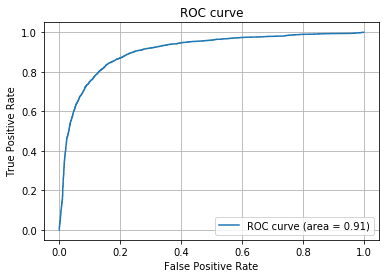

In [47]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)

auc = metrics.auc(fpr, tpr)

#plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
